In [ ]:
mlflow ui --port 8082 --backend-store-uri sqlite:///mlruns.db

In [81]:
import os
from joblib import dump, load
from warnings import filterwarnings, catch_warnings, simplefilter
from datetime import datetime

import mlflow
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import randint, uniform, loguniform

from sklearn import set_config
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV, ParameterSampler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PowerTransformer, FunctionTransformer, StandardScaler
from sklearn.compose import TransformedTargetRegressor, make_column_transformer, ColumnTransformer
from xgboost.sklearn import XGBRegressor

from src.evaluation import *
from src.feature_engineering import *
from src.utils import return_train_test_data
from src.data_visuals import histplots_grid
from src.tested_variants import cv_params_set

In [16]:
filterwarnings("ignore")
ConvergenceWarning("ignore")

mlflow.set_tracking_uri("sqlite:///mlruns.db")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

set_config(transform_output="pandas")

SEED = 42

In [17]:
file_path = os.path.join("data", "energydata_complete.csv")
data = pd.read_csv(file_path)

data.date = pd.to_datetime(data.date, format="%d-%m-%Y %H:%M")
data.set_index("date", inplace=True)

data["Appliances_24"] = data.Appliances.shift(-24*6) # target variable
data.dropna(inplace=True)

enhancer = DataEnhancer(data)
enhanced_data = (enhancer
                 .add_datetime_features()
                 .data)

enhanced_data.head(3)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,Appliances_24,day_of_week,hour,minute,time_of_day,week_of_year,day_of_year,is_holiday,is_weekend
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.2,41.626667,18.2,48.900000,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,60.0,Monday,17,0,evening,2,11,0,0
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.2,41.560000,18.2,48.863333,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,60.0,Monday,17,10,evening,2,11,0,0
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.2,41.433333,18.2,48.730000,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,210.0,Monday,17,20,evening,2,11,0,0


In [4]:
data.shape, enhanced_data.shape

((19591, 29), (19591, 37))

# Prediction benchmarks

For reference points in making predictions, the following options were adopted:

* Values from the previous week (same weekday and time).
* Historical averages for the specific hour and minute, calculated using training data.
* A simple linear regression model applied to the original dataset, which has been enhanced with basic datetime features (as above), MinMaxScaler and a logarithmic transformation of the target variable.

The scores achieved are presented below.

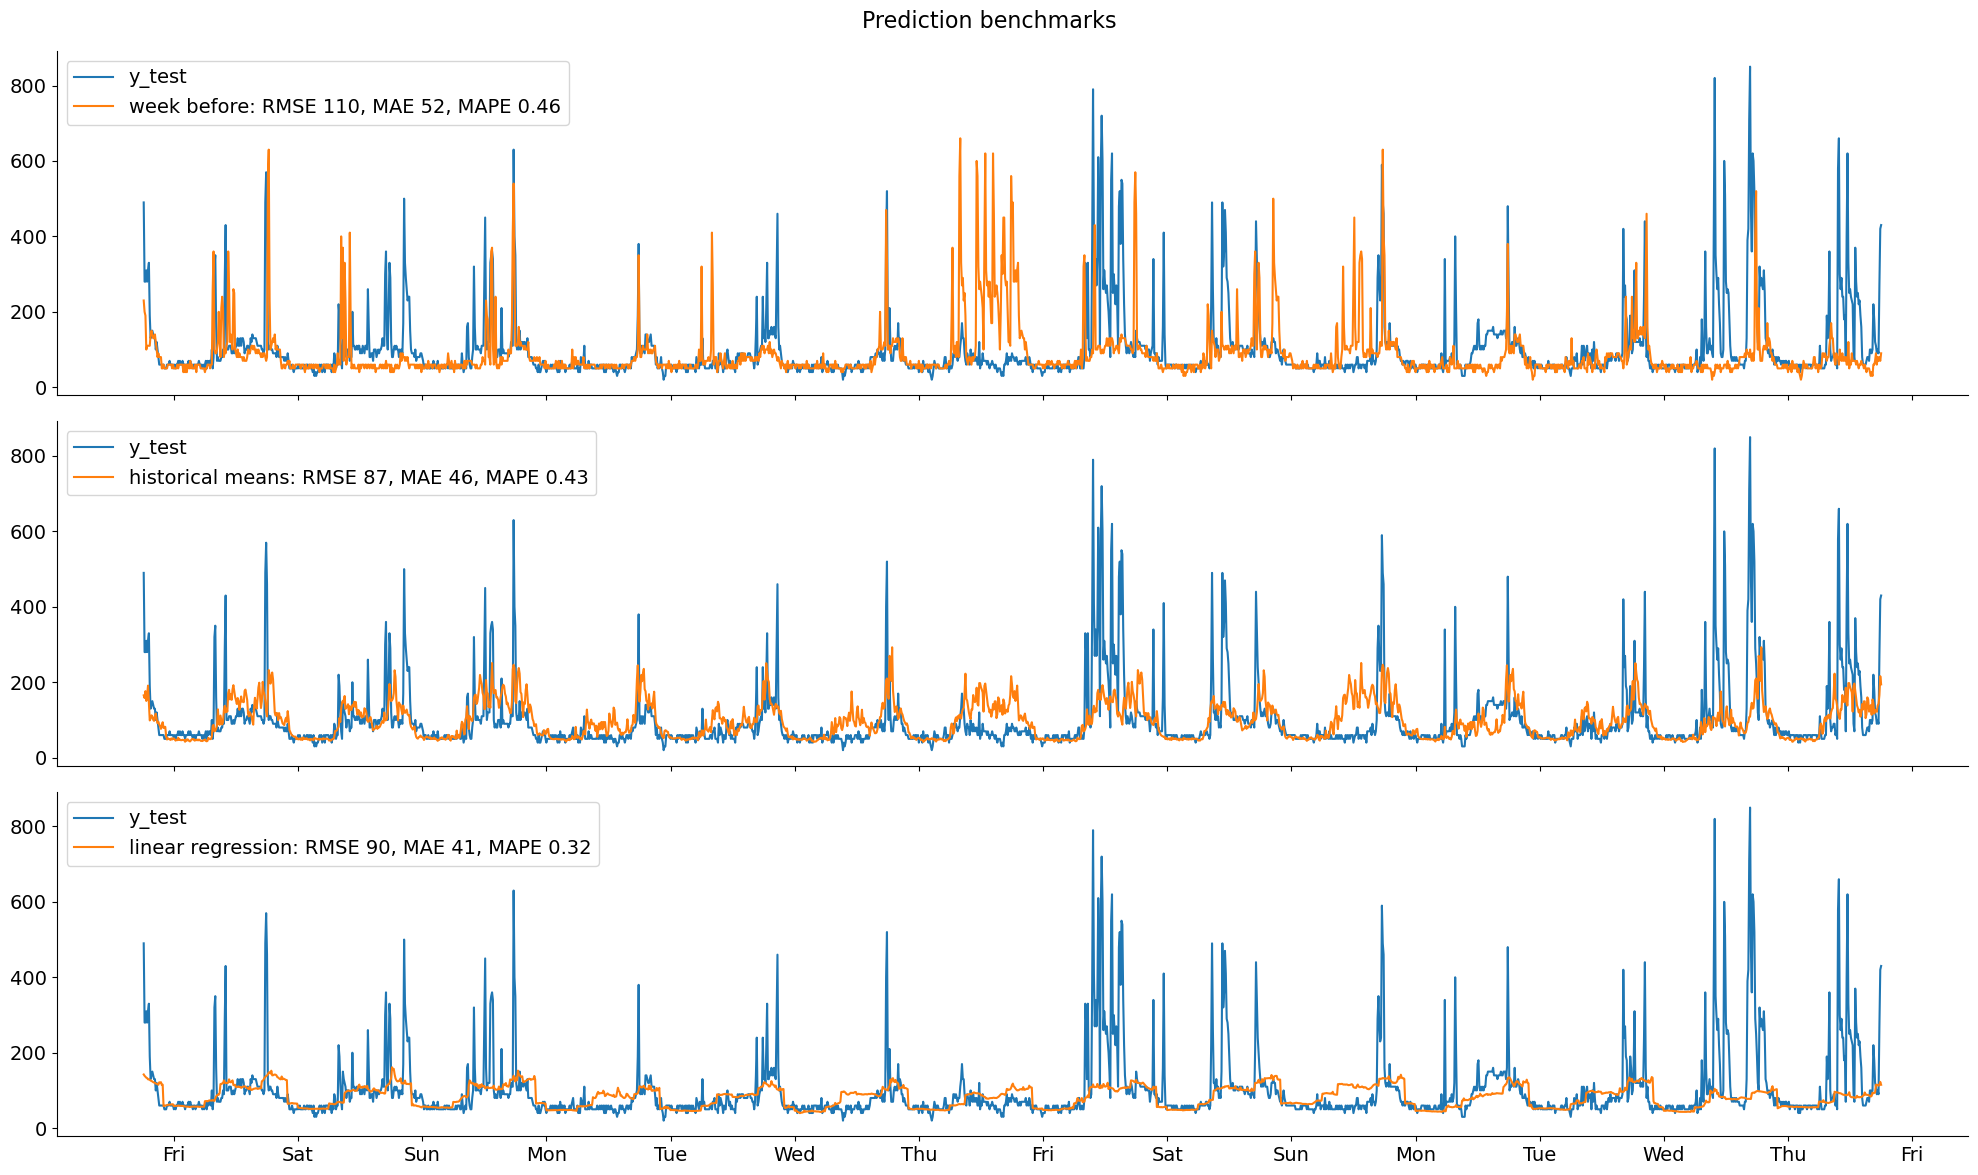

In [6]:
n_test = 2*144*7 # two weeks
prediction_benchmarks(enhanced_data, n_test)

# Experiments

In [8]:
# mlflow.create_experiment(name="Initial experiments")
mlflow.set_experiment("Initial experiments")

<Experiment: artifact_location='/home/kasia/DS/energy/Appliances_energy_prediction/mlruns/1', creation_time=1706538387137, experiment_id='1', last_update_time=1706538387137, lifecycle_stage='active', name='Initial experiments', tags={}>

In [18]:
lags = [1, 2, 3, 4, 5, 6, 72, 144]
mov_windows = [2, 6, 12, 72, 144]

enhanced_data = (enhancer
                 .drop_features(["RH_6"])
                 .mark_high_values()
                 .add_lagged_features(lags=lags)
                 .add_moving_average(windows=mov_windows)
                 .add_moving_sum(windows=mov_windows)
                 .dropna()
                 .data)

X_train_lin, X_test_lin, y_train, y_test = return_train_test_data(enhanced_data,
                                                                  n_test,
                                                                  xy=True,
                                                                  ohe_drop_first=True)
X_train_tree, X_test_tree, _, _  = return_train_test_data(enhanced_data,
                                                          n_test,
                                                          xy=True)
X_train_lin.head(3)

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,hour,minute,week_of_year,day_of_year,is_holiday,is_weekend,is_high_usage,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_72,lag_144,moving_av_2,moving_av_6,moving_av_12,moving_av_72,moving_av_144,moving_sum_2,moving_sum_6,moving_sum_12,moving_sum_72,moving_sum_144,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_evening,time_of_day_forenoon,time_of_day_morning,time_of_day_night
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-12 17:00:00,0.0,20.066667,42.833333,19.00,42.418182,19.79,44.700000,19.26,42.560000,17.6,50.90,6.156667,18.138889,37.905556,18.6,45.790000,17.1,43.260,6.50,744.200000,75.000000,7.0,29.000000,2.30,36.465481,36.465481,17.0,0.0,2.0,12.0,0.0,0.0,0.0,40.0,40.0,40.0,50.0,40.0,30.0,50.0,60.0,50.0,45.000000,39.166667,92.361111,104.097222,100.0,270.0,470.0,6650.0,14990.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2016-01-12 17:10:00,10.0,20.000000,42.672500,19.00,42.433333,19.79,44.663333,19.20,42.560000,17.6,50.90,6.090000,18.100000,37.945455,18.6,45.808333,17.1,43.200,6.32,744.283333,76.666667,7.0,30.833333,2.43,22.628542,22.628542,17.0,10.0,2.0,12.0,0.0,0.0,0.0,60.0,40.0,40.0,40.0,50.0,40.0,50.0,60.0,60.0,48.333333,40.833333,92.500000,104.097222,120.0,290.0,490.0,6660.0,14990.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2016-01-12 17:20:00,20.0,20.000000,42.530000,18.99,42.471818,19.79,44.590000,19.20,42.626667,17.6,50.79,6.090000,18.100000,38.045000,18.6,45.900000,17.1,43.145,6.13,744.366667,78.333333,7.0,32.666667,2.57,8.756338,8.756338,17.0,20.0,2.0,12.0,0.0,0.0,1.0,60.0,60.0,40.0,40.0,40.0,50.0,40.0,50.0,135.0,75.000000,55.000000,94.861111,105.208333,270.0,450.0,660.0,6830.0,15150.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [10]:
skewed_features = ([feature for feature in X_train_lin.columns
                   if feature.startswith("lag")
                   or feature.startswith("moving")]
                   + ["Windspeed", "lights"])
num_unique_values = X_train_lin.select_dtypes(exclude="object").nunique()
continuous_features = [col for col in num_unique_values.index if num_unique_values[col] > 3]

log_transformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)
sqrt_transformer = FunctionTransformer(func=np.sqrt, inverse_func=np.square)
target_transformations = [log_transformer, sqrt_transformer, None]
anomalies_marker = [AnomaliesMarker(contamination="auto"), "passthrough"]

log_pipe = Pipeline([
    ("log_tr", make_column_transformer(
        (log_transformer, skewed_features),
        remainder="passthrough")),
    ("scaler", StandardScaler()),
])

power_tr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("power_tr", make_column_transformer(
        (PowerTransformer(), skewed_features),
        remainder="passthrough")),
])

preprocessor = Pipeline([
    ("col_tr", ColumnTransformer([
        ("continuous", log_pipe, continuous_features)
    ], remainder="passthrough")),
    ("marker", AnomaliesMarker())
])

In [11]:
X_train_tree.shape, preprocessor.fit_transform(X_train_tree).shape

((17431, 63), (17431, 64))

In [20]:
EN, Ri, ETR, HGBR, RFR, XGBR = (ElasticNet(max_iter=5000),
                                Ridge(),
                                ExtraTreesRegressor(n_jobs=-1),
                                HistGradientBoostingRegressor(),
                                RandomForestRegressor(n_jobs=-1),
                                XGBRegressor())

models = [model.set_params(random_state=SEED) for model in [EN, Ri, ETR, HGBR, RFR, XGBR]]

for_linear_preprocessor = {
    "regressor__preprocessor__col_tr__continuous": [log_pipe, power_tr_pipe],
    "regressor__preprocessor__marker": anomalies_marker,
    "transformer": target_transformations
}
for_tree_preprocessor = {
    "regressor__preprocessor__col_tr": ["passthrough"],
    "regressor__preprocessor__marker": anomalies_marker,
    "transformer": target_transformations
}

params = [
    {
        "regressor__model__alpha": loguniform(1e-2, 1e2),
        "regressor__model__l1_ratio": uniform(0, 1),
        **for_linear_preprocessor
    },
    {
        "regressor__model__alpha": loguniform(1e-3, 1e2),
        **for_linear_preprocessor
    },
    {
        "regressor__model__n_estimators": randint(100, 200),
        "regressor__model__max_depth": randint(3, 10),
        "regressor__model__min_samples_leaf": randint(5, 50),
        **for_tree_preprocessor
    },
    {
        "regressor__model__learning_rate": loguniform(1e-4, 1e0),
        "regressor__model__max_iter": randint(50, 200),
        "regressor__model__max_depth": randint(3, 10),
        "regressor__model__min_samples_leaf": randint(5, 50),
        **for_tree_preprocessor
    },
    {
        "regressor__model__n_estimators": randint(100, 200),
        "regressor__model__max_depth": randint(3, 10),
        "regressor__model__min_samples_leaf": randint(5, 50),
        **for_tree_preprocessor
    },
    {
        "regressor__model__n_estimators": randint(50, 200),
        "regressor__model__max_depth": randint(3, 10),
        "regressor__model__subsample": uniform(0.5, 0.5),
        "regressor__model__colsample_bytree": uniform(0.5, 0.5),
        "regressor__model__min_child_weight": randint(5, 50),
        "regressor__model__eta": loguniform(1e-4, 1e0),
        "regressor__model__gamma": loguniform(1e-4, 1e1),
        "regressor__model__lambda": loguniform(1e-4, 1e1),
        **for_tree_preprocessor
    }
]

In [22]:
all_cv_results = []

for i, cv_params in enumerate(params_set):

    with mlflow.start_run(run_name=f"CV params {i}",
                          tags={"level": "parent"}) as parent_run:
        
        tscv = TimeSeriesSplit(**cv_params)

        mlflow.log_params({
            "lags": lags,
            "moving_windows": mov_windows,
            "tscv_n_splits": tscv.n_splits,
            "tscv_gap": tscv.gap,
            "tscv_test_size": tscv.test_size,
            "tscv_max_test_size": tscv.max_train_size,
            "optimization": "rmse"
        })
        parent_run_id = mlflow.active_run().info.run_id

        for model, param in zip(models, params):

            name = model.__class__.__name__

            with mlflow.start_run(run_name=f"{name}",
                                  nested=True,
                                  tags={"level": "child"}) as child_run:

                pipeline = Pipeline([("preprocessor", preprocessor),
                                     ("model", model)])

                optimizer = RandomizedSearchCV(estimator=TransformedTargetRegressor(pipeline), 
                                               param_distributions=param, 
                                               cv=tscv,
                                               n_iter=100, 
                                               scoring={"rmse": "neg_root_mean_squared_error",
                                                        "mae": "neg_mean_absolute_error",
                                                        "mape": "neg_mean_absolute_percentage_error"},
                                               refit="rmse",
                                               n_jobs=-1,
                                               error_score="raise",
                                               return_train_score=True,
                                               random_state=SEED)

                if name in ["Ridge", "ElasticNet"]:
                    X_train, X_test = X_train_lin, X_test_lin
                else:
                    X_train, X_test = X_train_tree, X_test_tree

                with catch_warnings():
                    simplefilter("ignore")
                    optimizer.fit(X_train, y_train)

                input_example = X_test[:10]
                output_example = optimizer.best_estimator_.predict(input_example)

                input_shape = X_train.shape
                cv_results = optimizer.cv_results_
                child_run_id = mlflow.active_run().info.run_id
                
                results = pd.DataFrame(cv_results)
                to_drop = [col for col in results.columns if "param" in col or "time" in col]
                selected_results = results.drop(to_drop, axis=1)
                selected_results = np.abs(selected_results)

                new_frame = pd.DataFrame({
                        "model": [name] * len(results),
                        "tscv_n_splits": [tscv.n_splits for _ in range(len(results))],
                        "tscv_gap": [tscv.gap for _ in range(len(results))],
                        "tscv_test_size": [tscv.test_size for _ in range(len(results))],
                        "tscv_max_test_size": [tscv.max_train_size for _ in range(len(results))],
                        "optimization": ["rmse"] * len(results),
                        "parent_run_id": [parent_run_id for _ in range(len(results))],
                        "child_run_id": [child_run_id for _ in range(len(results))]
                    })
                results = pd.concat([selected_results, new_frame], axis=1)
                all_cv_results.append(results)

                mlflow.log_params(optimizer.best_params_)
                mlflow.log_param("input_shape", input_shape)
                mlflow.set_tags({"model": name,
                                 "optimization": "rmse"})

                for metric in ["rmse", "mae", "mape"]:
                    best_index = np.argmax(cv_results[f"mean_test_{metric}"])
                    best_score = cv_results[f"mean_test_{metric}"][best_index]
                    std = cv_results[f"std_test_{metric}"].mean()

                    mlflow.log_metrics({f"best_{metric}": np.abs(best_score),
                                        f"std_{metric}": std})

                signature = mlflow.models.infer_signature(input_example,
                                                          output_example)

                mlflow.sklearn.log_model(sk_model=optimizer.best_estimator_,
                                         artifact_path="",
                                         signature=signature,
                                         registered_model_name=name)
                print(name, f"i = {i}", "rmse =", np.abs(optimizer.best_score_))

all_cv_results = pd.concat(all_cv_results, axis=0)
all_cv_results.to_feather("mlruns/1/cv_results.feather")

In [175]:
all_cv_results = pd.read_feather("mlruns/1/cv_results.feather")
all_cv_results[(all_cv_results.child_run_id == "42bcecbd3e2d4c5f8183e36e76d3e464") & (all_cv_results.rank_test_rmse == 1)]

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_train_rmse,split1_train_rmse,split2_train_rmse,split3_train_rmse,split4_train_rmse,mean_train_rmse,std_train_rmse,split0_test_mae,split1_test_mae,split2_test_mae,split3_test_mae,split4_test_mae,mean_test_mae,std_test_mae,rank_test_mae,split0_train_mae,split1_train_mae,split2_train_mae,split3_train_mae,split4_train_mae,mean_train_mae,std_train_mae,split0_test_mape,split1_test_mape,split2_test_mape,split3_test_mape,split4_test_mape,mean_test_mape,std_test_mape,rank_test_mape,split0_train_mape,split1_train_mape,split2_train_mape,split3_train_mape,split4_train_mape,mean_train_mape,std_train_mape,model,tscv_n_splits,tscv_gap,tscv_test_size,tscv_max_test_size,optimization,parent_run_id,child_run_id,split5_test_rmse,split6_test_rmse,split7_test_rmse,split8_test_rmse,split9_test_rmse,split5_train_rmse,split6_train_rmse,split7_train_rmse,split8_train_rmse,split9_train_rmse,split5_test_mae,split6_test_mae,split7_test_mae,split8_test_mae,split9_test_mae,split5_train_mae,split6_train_mae,split7_train_mae,split8_train_mae,split9_train_mae,split5_test_mape,split6_test_mape,split7_test_mape,split8_test_mape,split9_test_mape,split5_train_mape,split6_train_mape,split7_train_mape,split8_train_mape,split9_train_mape
7,89.500694,99.104791,95.723333,76.762334,110.988308,89.031915,12.233664,1,87.755746,87.133762,87.885952,87.729515,86.878604,86.623195,1.264418,49.454883,49.634739,50.989433,44.395861,55.023365,47.743146,4.217495,64,48.640388,47.900066,48.284512,48.16515,47.073063,46.915102,1.37058,0.618207,0.442823,0.541195,0.514277,0.511682,0.503585,0.046731,64,0.551678,0.548664,0.545571,0.544703,0.528946,0.526036,0.021494,ExtraTreesRegressor,10,0,1008,NaN,rmse,e40ce746e6c84650860c3a6dcda0f9ef,42bcecbd3e2d4c5f8183e36e76d3e464,90.044972,100.310789,70.978302,82.898862,74.006761,87.349299,86.566324,86.226032,84.886248,83.820471,49.166929,51.095266,41.312173,43.593771,42.765035,47.115302,46.571699,46.086343,45.066295,44.248204,0.48193,0.488187,0.50366,0.46359,0.470299,0.52877,0.518589,0.509296,0.497601,0.486537


In [152]:
grouped_data = (all_cv_results
                .groupby(["parent_run_id"])[["std_test_mae", "std_train_mae",
                                             "std_test_mape", "std_train_mape",
                                             "std_test_rmse", "std_train_rmse",
                                             "mean_test_mae", "mean_train_mae",
                                             "mean_test_mape", "mean_train_mape",
                                             "mean_test_rmse", "mean_train_rmse"]]
                .mean()
                .reset_index())

grouped_data["diff_mae"] = grouped_data["mean_test_mae"] - grouped_data["mean_train_mae"]
grouped_data["diff_mape"] = grouped_data["mean_test_mape"] - grouped_data["mean_train_mape"]
grouped_data["diff_rmse"] = grouped_data["mean_test_rmse"] - grouped_data["mean_train_rmse"]
grouped_data["diff_std_mae"] = grouped_data["std_test_mae"] - grouped_data["std_train_mae"]
grouped_data["diff_std_mape"] = grouped_data["std_test_mape"] - grouped_data["std_train_mape"]
grouped_data["diff_std_rmse"] = grouped_data["std_test_rmse"] - grouped_data["std_train_rmse"]

grouped_data

,parent_run_id,std_test_mae,std_train_mae,std_test_mape,std_train_mape,std_test_rmse,std_train_rmse,mean_test_mae,mean_train_mae,mean_test_mape,mean_train_mape,mean_test_rmse,mean_train_rmse,diff_mae,diff_mape,diff_rmse,diff_std_mae,diff_std_mape,diff_std_rmse
0,0bcc66d2fcc64908b176bbff8e3e007a,5.901625,1.451895,0.080491,0.020645,8.836462,2.114821,50.672306,48.623761,0.526966,0.518286,96.722344,94.017768,2.048545,0.008680,2.704577,4.449730,0.059847,6.721641
1,136671494b5244f9bc3e6f5415eb97cc,6.407258,2.505703,0.092483,0.042164,10.181598,3.458082,51.276719,44.612419,0.535437,0.465288,97.970220,87.762528,6.664299,0.070149,10.207692,3.901555,0.050319,6.723515
2,3b50f462e0e848b69e735b5b2e23c7a6,6.073081,2.016102,0.090578,0.038701,9.581258,2.420147,51.920512,42.630085,0.547959,0.439628,97.710082,84.469241,9.290427,0.108330,13.240841,4.056980,0.051877,7.161111
3,3ea93ac597384c8ba0626045b53b9945,18.408644,2.134888,0.314116,0.037560,18.741383,2.644829,60.122444,42.547989,0.691897,0.435362,102.047983,83.769484,17.574455,0.256534,18.278499,16.273757,0.276556,16.096554
4,88280583615544f7b18b8cc13da96841,6.429401,2.982858,0.094942,0.041775,8.960260,4.635124,52.681965,44.748323,0.558553,0.469643,98.395598,87.405194,7.933642,0.088910,10.990405,3.446543,0.053167,4.325136
5,b4fbb315c93a47e3b1a02173f1d71ed3,6.205169,3.030821,0.090323,0.041928,9.066657,4.689223,51.180740,46.170358,0.532359,0.488596,97.483656,89.735185,5.010382,0.043763,7.748470,3.174348,0.048395,4.377434
6,e40ce746e6c84650860c3a6dcda0f9ef,7.621425,1.085488,0.091753,0.018386,14.106968,1.366275,51.193503,47.975415,0.532414,0.508160,96.641833,93.490189,3.218088,0.024254,3.151644,6.535937,0.073367,12.740693
7,e45a91d473c84fe78789a5ac7d1a627e,8.956596,2.336949,0.122578,0.041047,14.311590,3.035604,52.541205,44.457828,0.555745,0.460039,97.837866,87.645267,8.083377,0.095707,10.192600,6.619647,0.081531,11.275986
8,ef7f705193ab4635bb79c4434ccd3b79,11.370472,1.281675,0.162043,0.019184,17.013634,1.844301,53.131495,48.585316,0.567516,0.517486,98.226731,94.036430,4.546179,0.050030,4.190302,10.088797,0.142860,15.169333
9,f04a9757cc29438e8027941198cc6392,9.071921,2.040688,0.115752,0.037850,14.557543,2.595001,53.134339,41.038460,0.567439,0.413216,97.252939,82.155660,12.095879,0.154223,15.097279,7.031233,0.077902,11.962542


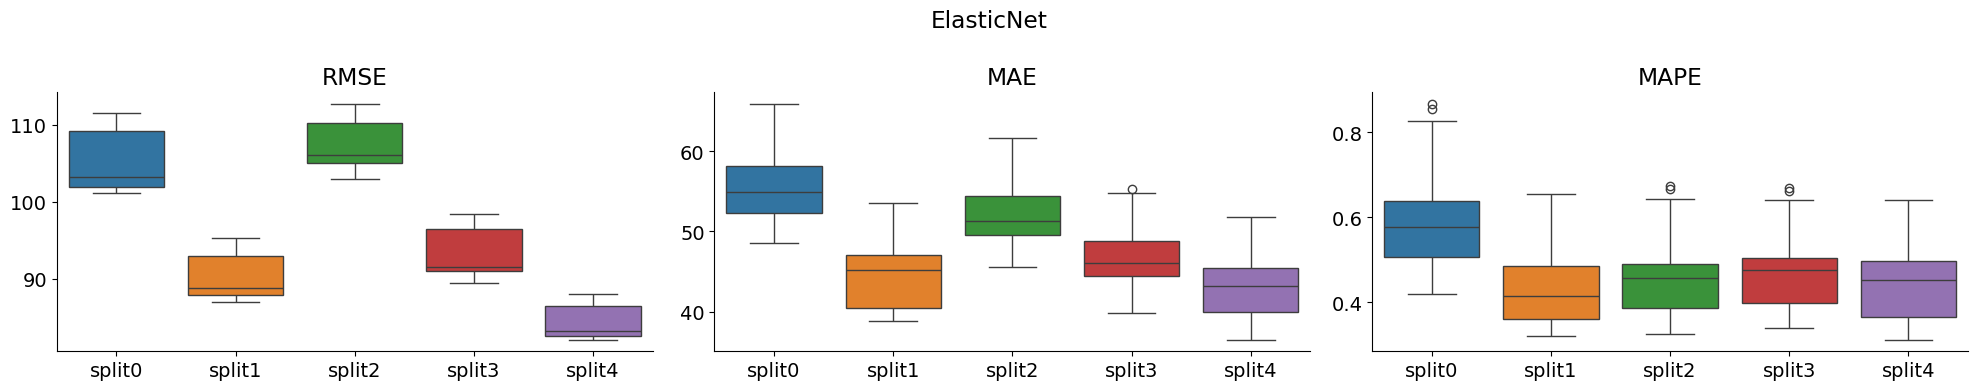

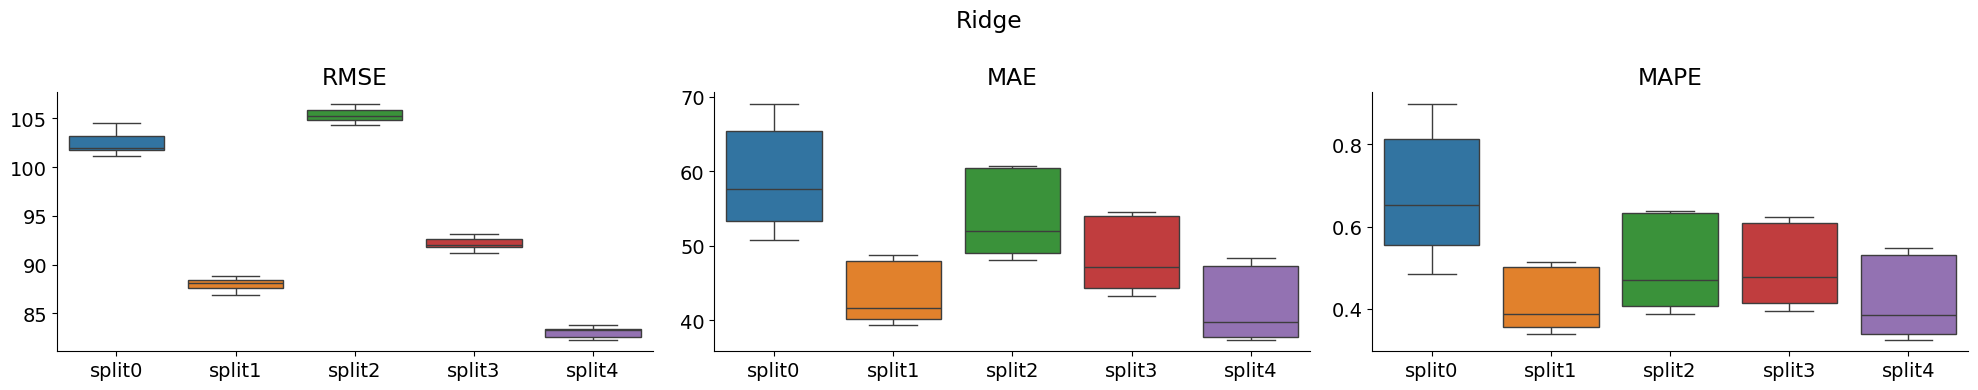

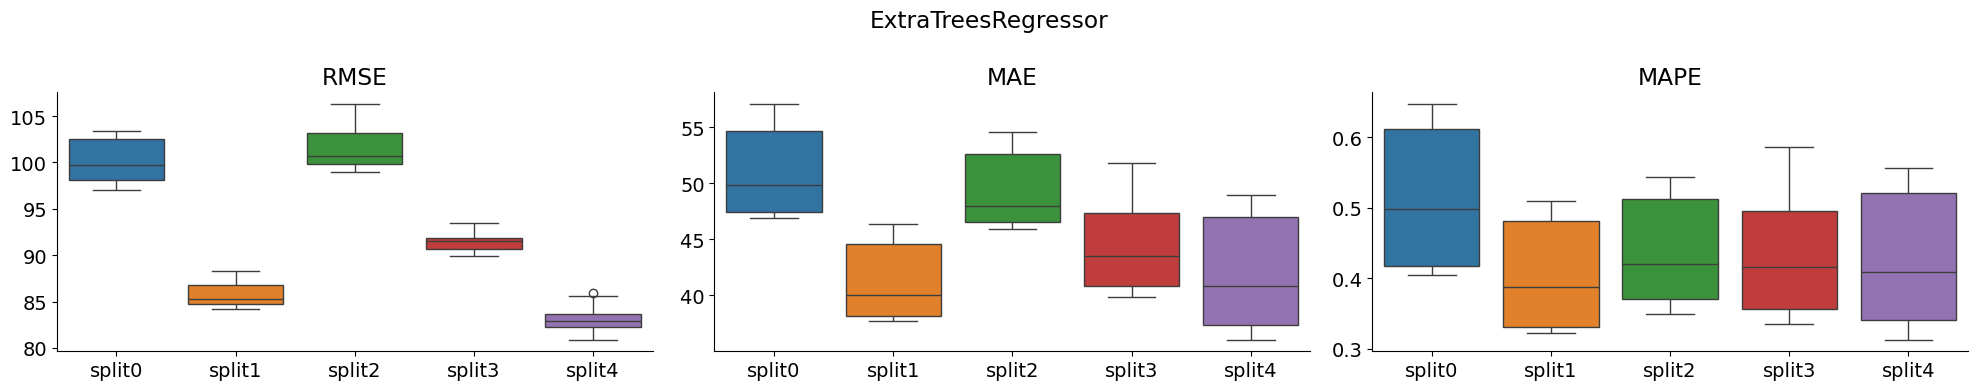

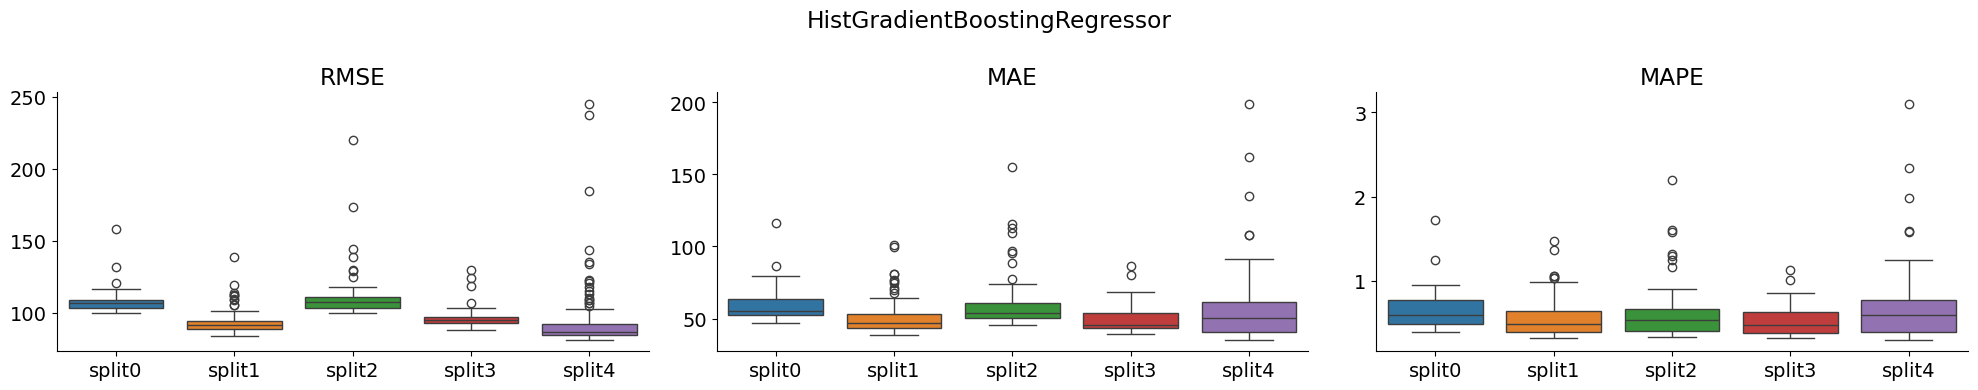

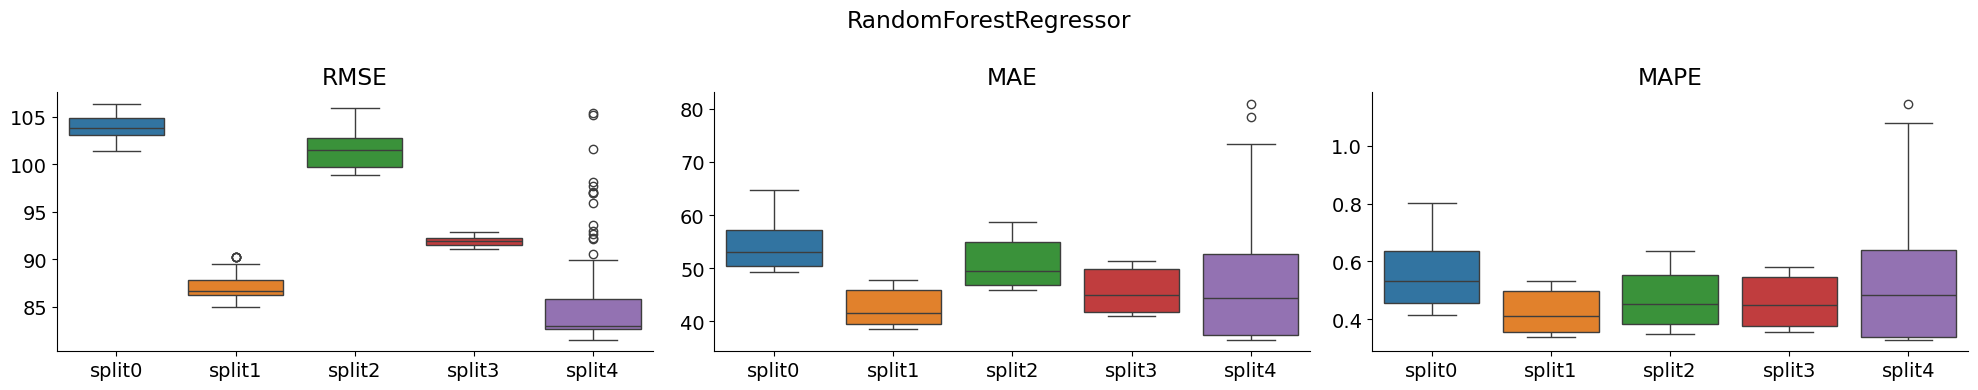

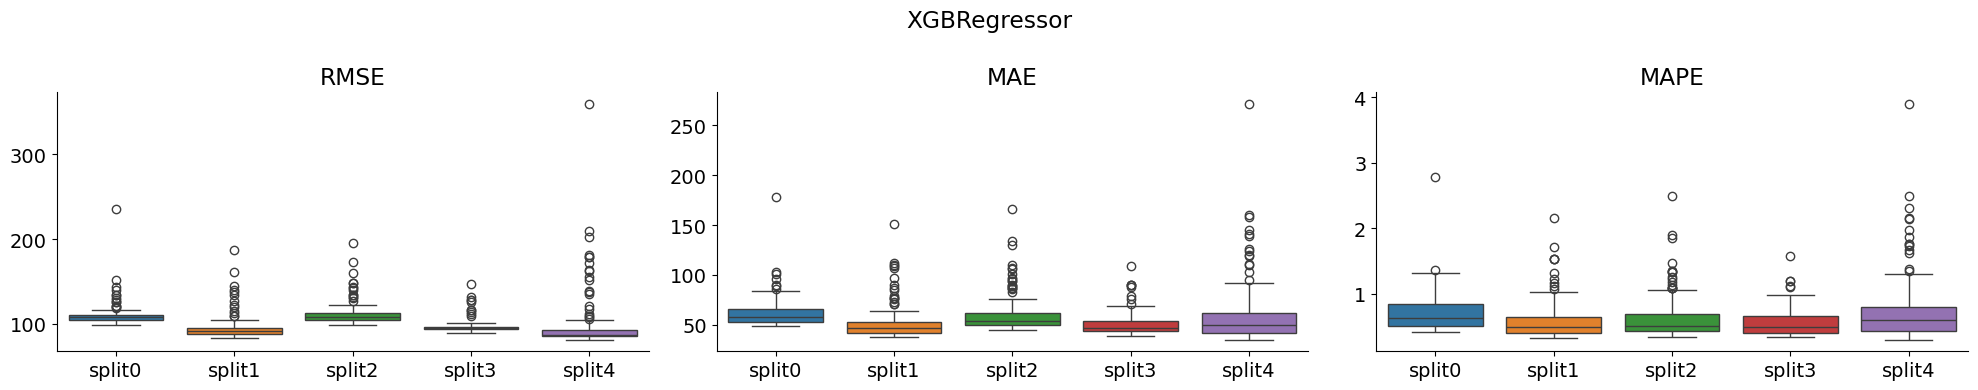

In [170]:
filtered_data = all_cv_results[all_cv_results['parent_run_id'] == "0bcc66d2fcc64908b176bbff8e3e007a"]

rmse_columns = [col for col in filtered_data.columns if "test_rmse" in col and "split" in col and filtered_data[col].notna().any()]
mae_columns = [col for col in filtered_data.columns if "test_mae" in col and "split" in col and filtered_data[col].notna().any()]
mape_columns = [col for col in filtered_data.columns if "test_mape" in col and "split" in col and filtered_data[col].notna().any()]

def create_boxplots(data, model, columns_set, titles):
    fig, axes = plt.subplots(1, 3, figsize=(20, 4))
    fig.suptitle(model)
    for i, (columns, title) in enumerate(zip(columns_set, titles)):
        sns.boxplot(data=data[columns], ax=axes[i])
        axes[i].set_xticklabels([col.split("_")[0] for col in columns], rotation=0)
        axes[i].set_title(title)
    plt.tight_layout()
    plt.show()

for model in filtered_data["model"].unique():
    model_data = filtered_data[filtered_data["model"] == model]
    create_boxplots(model_data, model, [rmse_columns, mae_columns, mape_columns], ["RMSE", "MAE", "MAPE"])

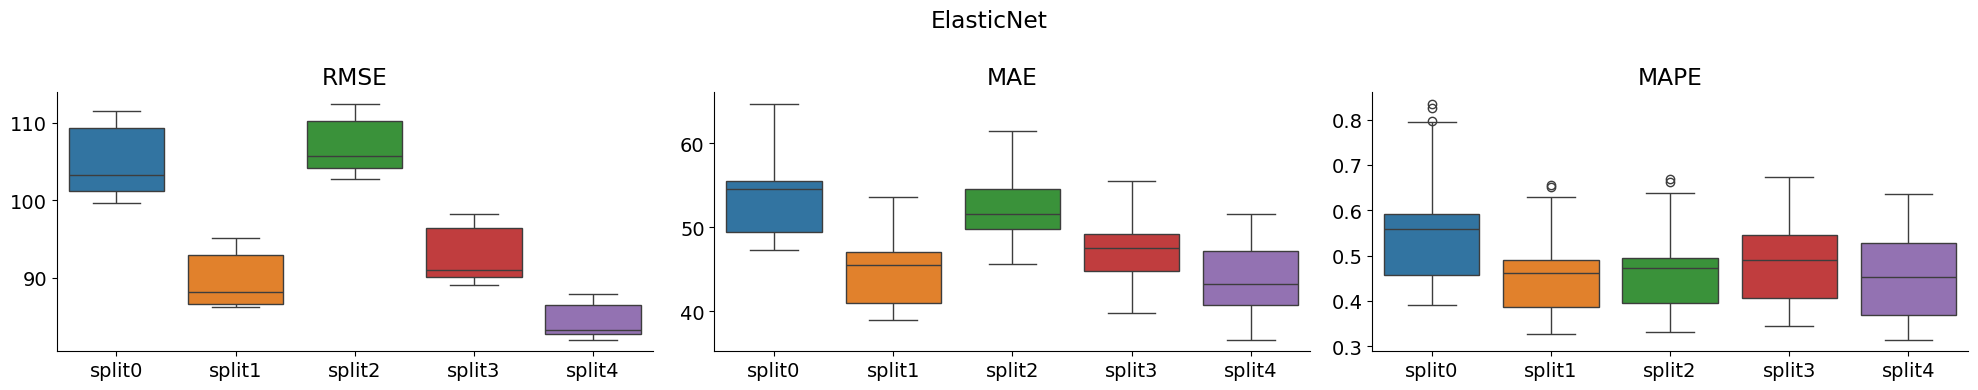

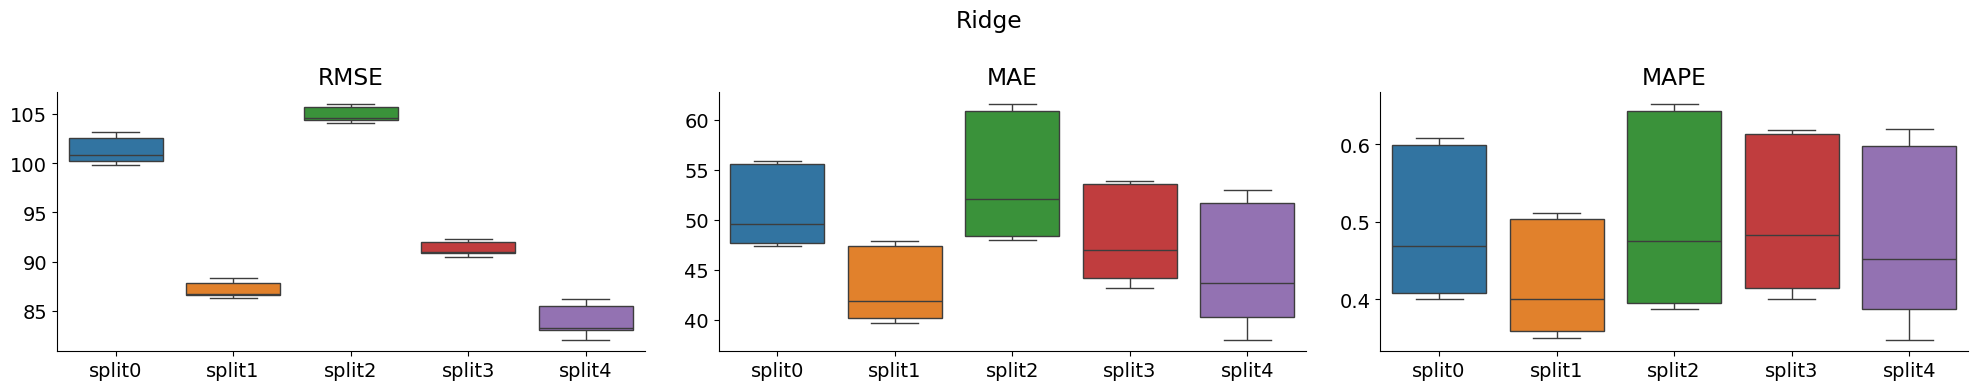

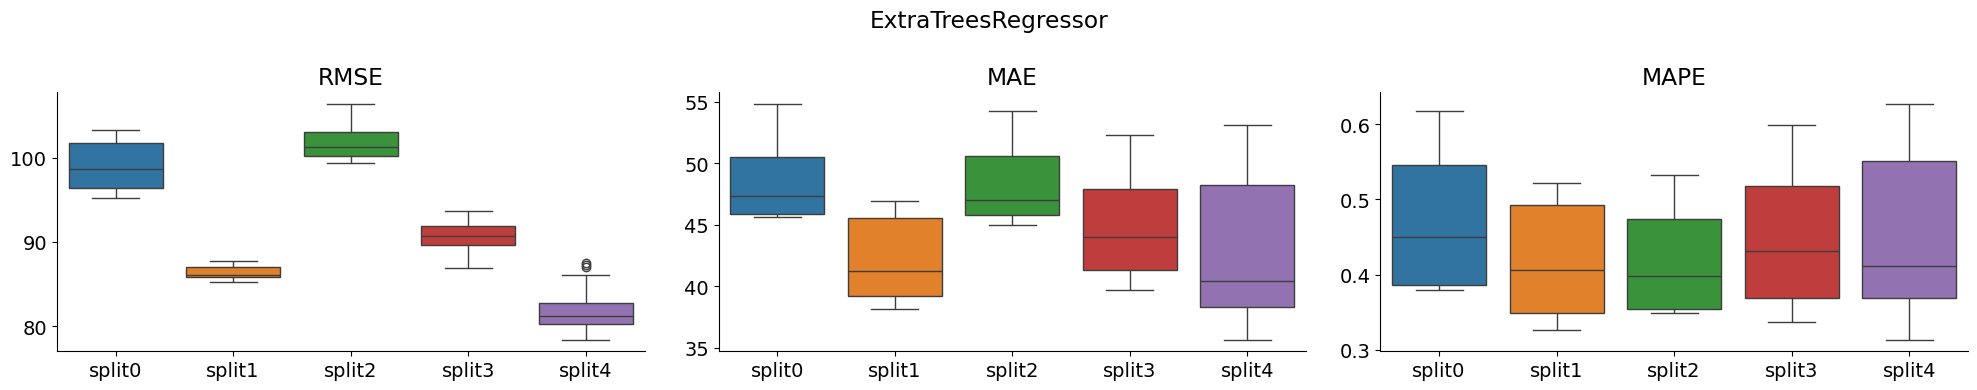

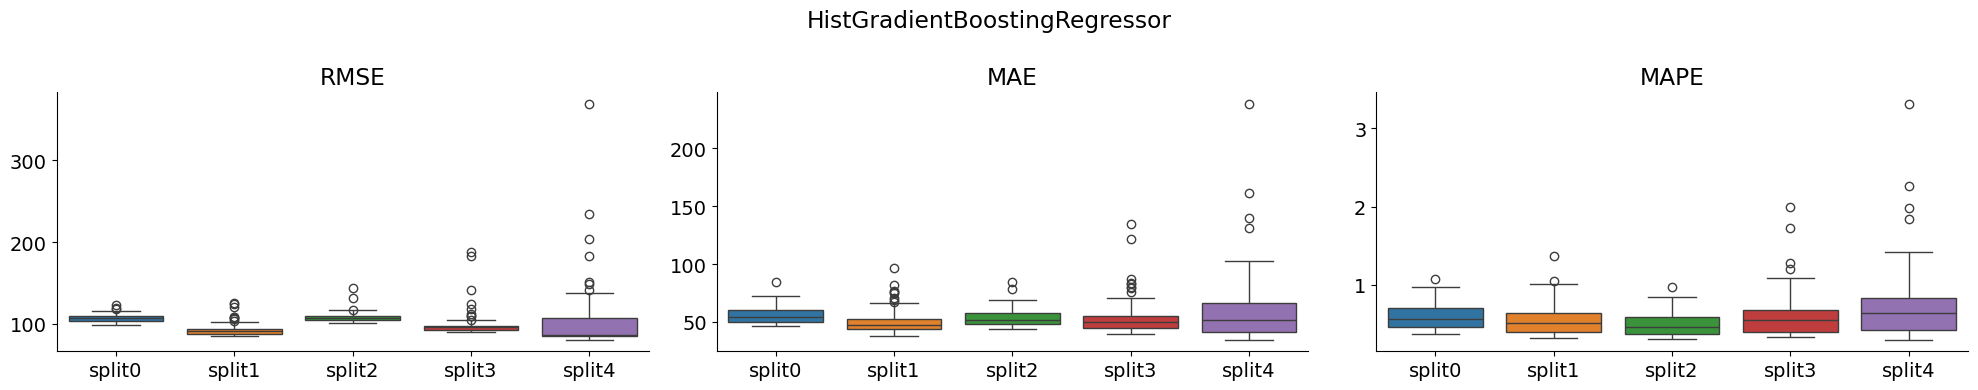

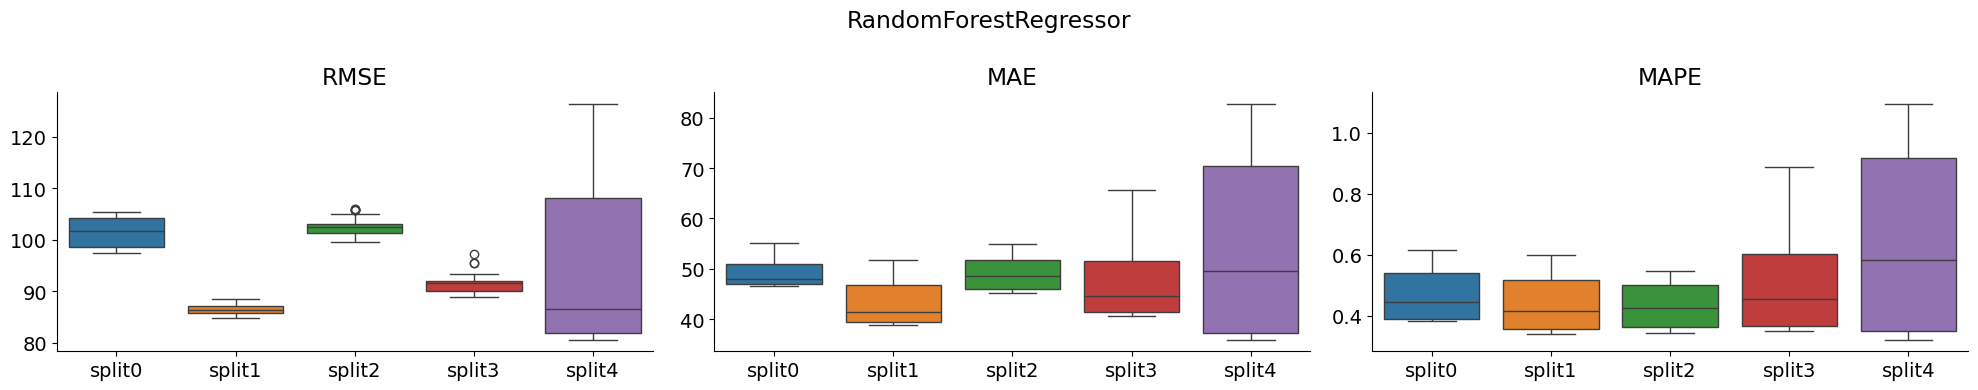

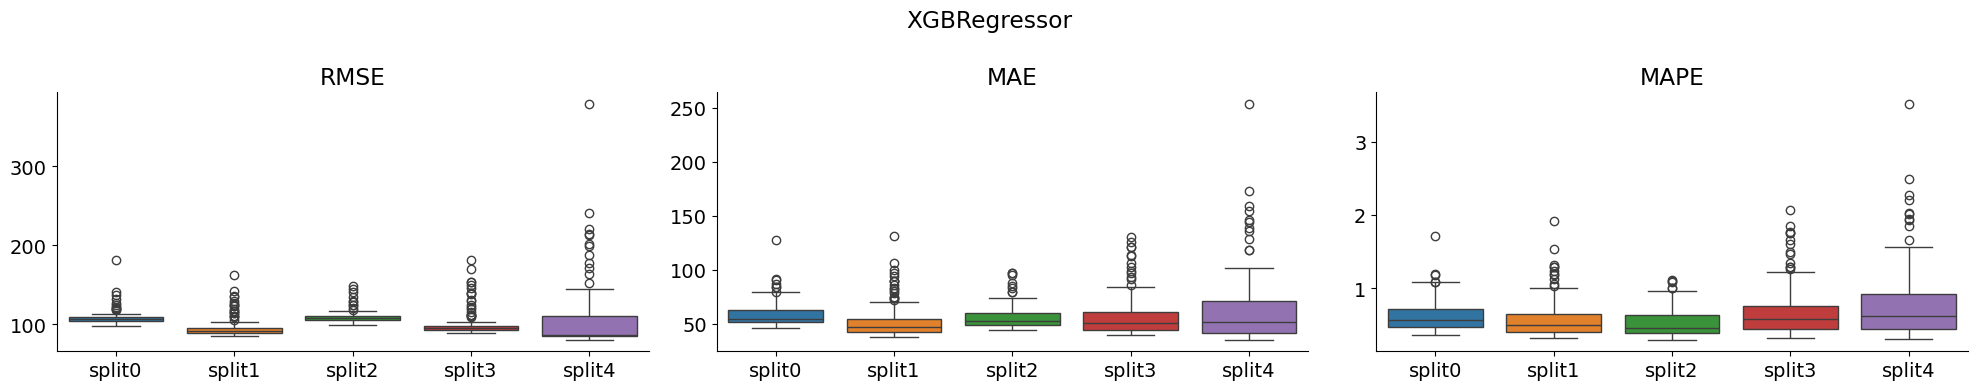

In [148]:
filtered_data = all_cv_results[all_cv_results["parent_run_id"] == "f3fbbda7e20044689da234799ca3d71b"]

rmse_columns = [col for col in filtered_data.columns if "test_rmse" in col and "split" in col and filtered_data[col].notna().any()]
mae_columns = [col for col in filtered_data.columns if "test_mae" in col and "split" in col and filtered_data[col].notna().any()]
mape_columns = [col for col in filtered_data.columns if "test_mape" in col and "split" in col and filtered_data[col].notna().any()]

for model in filtered_data["model"].unique():
    model_data = filtered_data[filtered_data["model"] == model]
    create_boxplots(model_data, model, [rmse_columns, mae_columns, mape_columns], ["RMSE", "MAE", "MAPE"])

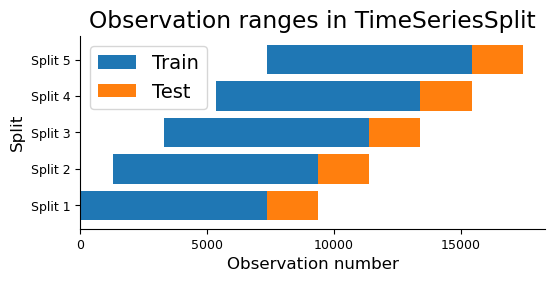

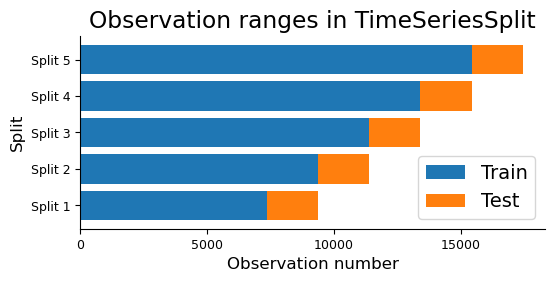

In [150]:
for cv_params in (cv_params_set[0], cv_params_set[4]):
    tscv = TimeSeriesSplit(**cv_params)
    time_series_split(tscv, X_train_tree, 1)

## Best model so far:

In [25]:
conn = sqlite3.connect("mlruns.db")

artifact_uri = pd.read_sql(
    """
    SELECT artifact_uri
    FROM runs
    JOIN metrics ON metrics.run_uuid = runs.run_uuid
    WHERE key = 'best_rmse'
    ORDER BY value ASC
    LIMIT 1
    """,
    conn
).iloc[0, 0]

conn.close()

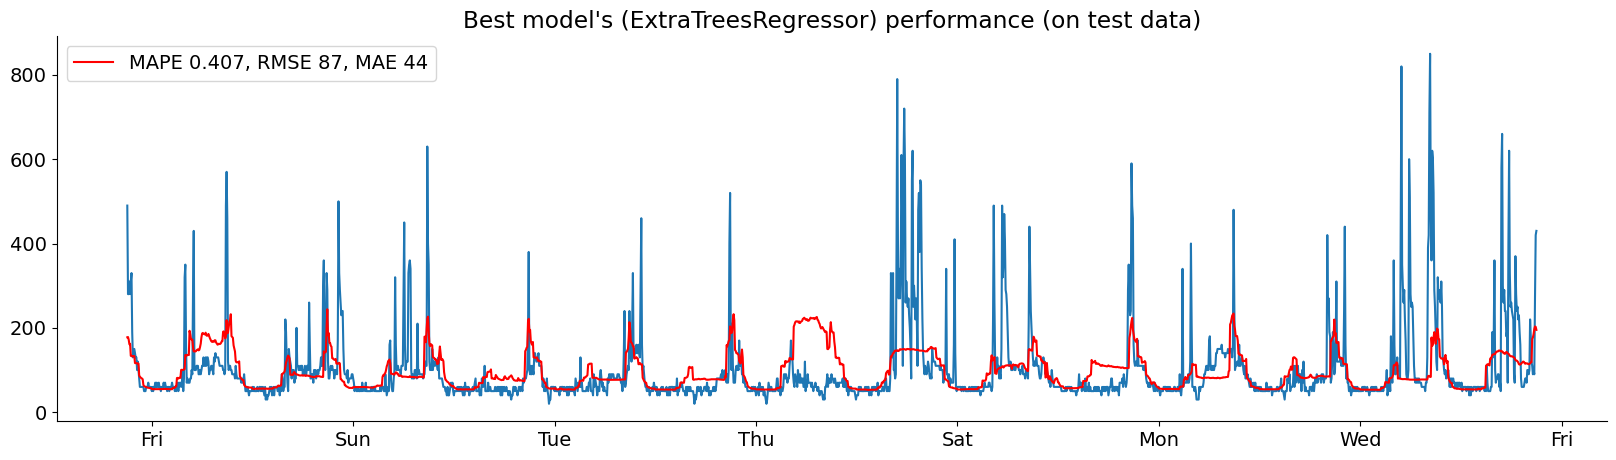

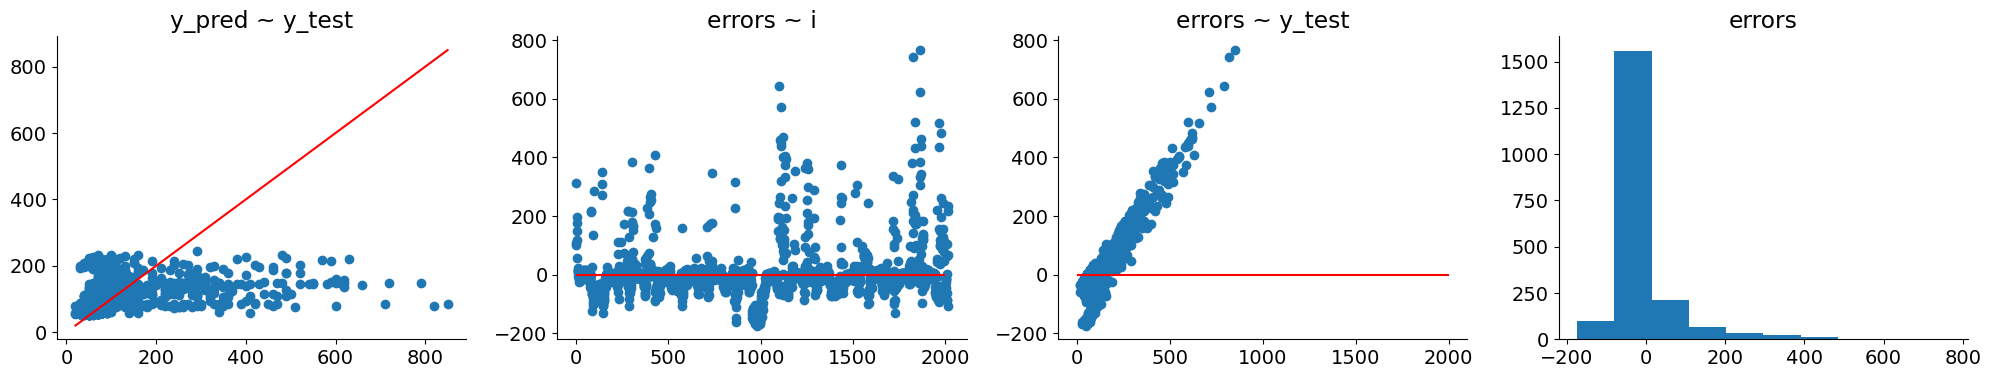

In [176]:
loaded_model = mlflow.sklearn.load_model(artifact_uri)

evaluate_model(X_test_tree, y_test, loaded_model)

In [116]:
# loaded_model.get_params

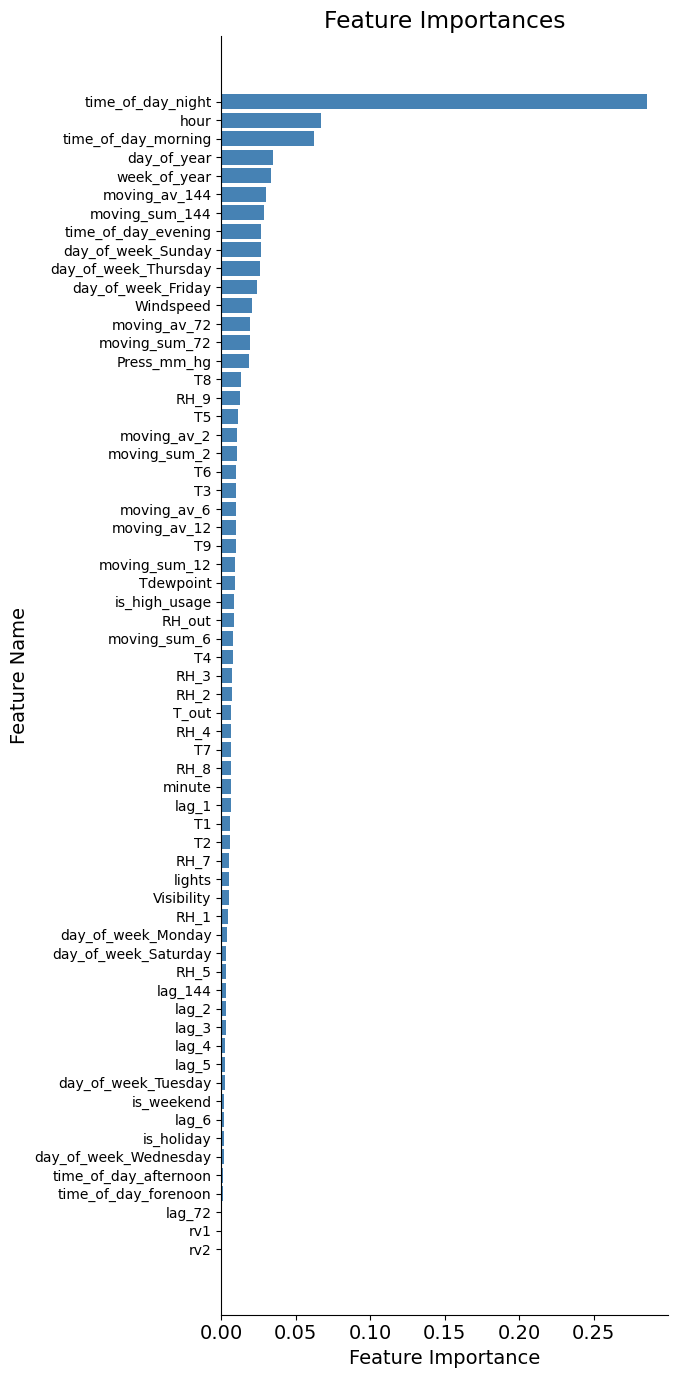

In [169]:
# np.set_printoptions(suppress=True, precision=8)
importances = loaded_model.regressor_.named_steps["model"].feature_importances_
cols = list(X_train_tree.columns)
# cols.append("anomalies")
feature_importances(importances, cols)